In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

# Ref: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py
# Install: pip install timm
import timm
from timm.models.efficientnet import default_cfgs 

from tensorboardX import SummaryWriter

import os
import shutil
import sys
import time
from glob import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from torchvision import transforms as T

from sklearn.model_selection import train_test_split

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
npy_path = glob("./datasets/training_data_5d/train/*.npy")
df = pd.Series(npy_path,name="npy_path").to_frame()
df['classes'] = df['npy_path'].apply(lambda x: int(x.split('.')[1][-1])-1)
# df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[2])
df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[3])
df

,npy_path,classes,area_id
0,./datasets/training_data_5d/train/train_0000_0...,0,0000
1,./datasets/training_data_5d/train/train_0001_0...,0,0001
2,./datasets/training_data_5d/train/train_0001_0...,0,0001
3,./datasets/training_data_5d/train/train_0002_0...,0,0002
4,./datasets/training_data_5d/train/train_0002_0...,0,0002
...,...,...,...
5914,./datasets/training_data_5d/train/train_1315_0...,2,1315
5915,./datasets/training_data_5d/train/train_1316_0...,2,1316
5916,./datasets/training_data_5d/train/train_1316_0...,2,1316
5917,./datasets/training_data_5d/train/train_1316_0...,2,1316


In [4]:
train_id,test_id = train_test_split(df['area_id'].unique(), test_size=0.1, random_state=42)

# df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)
df_train = df.loc[[(i in train_id) for i in df['area_id']]]
df_val = df.loc[[(i in test_id) for i in df['area_id']]]

df_train.shape,df_val.shape

((5446, 3), (473, 3))

In [5]:
df_train['classes'].value_counts()

0    2398
2    1913
1     577
3     558
Name: classes, dtype: int64

In [6]:
df_downsample = pd.concat([df_train[df_train['classes']==0].sample(600),df_train[df_train['classes']==2].sample(600)]+[df_train[df_train['classes']==1],df_train[df_train['classes']==3]])
df_downsample = df_downsample.sample(frac=1).reset_index(drop=True)
df_downsample['classes'].value_counts()

2    600
0    600
1    577
3    558
Name: classes, dtype: int64

In [7]:
df_upsample = pd.concat([df_train[df_train['classes']==0],df_train[df_train['classes']==2],df_train[df_train['classes']==2].sample(400)]+[df_train[df_train['classes']==1],df_train[df_train['classes']==3]]*4)
df_upsample = df_upsample.sample(frac=1).reset_index(drop=True)
df_upsample['classes'].value_counts()

0    2398
2    2313
1    2308
3    2232
Name: classes, dtype: int64

In [8]:
# Dataset Loader
class SatDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.npy_path = list(df['npy_path'])
        self.label = list(df['classes'])

    def __len__(self):
        return len(self.npy_path)
    def __getitem__(self, idx):
        data = np.load(self.npy_path[idx])
        data = torch.from_numpy(np.swapaxes(data, -3, -1)).float()
        return {'image': data, 'label': self.label[idx]}

train_dataset = SatDataset(df_upsample)
val_dataset = SatDataset(df_val)


# dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [37]:
# class ClassifierModel(torch.nn.Module):
#     def __init__(self,num_class=4):
#         super(ClassifierModel, self).__init__() 
#         self.backbone = torch.nn.Sequential(
#             torch.nn.Conv2d(36, 48, kernel_size=5),
#             torch.nn.BatchNorm2d(48),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(48, 64, kernel_size=5),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(64, 128, kernel_size=5),
#             torch.nn.BatchNorm2d(128),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(128, 256, kernel_size=4),
#             torch.nn.LeakyReLU(),
#             torch.nn.Flatten()
#             )
#         self.classifier = torch.nn.Sequential(
#             torch.nn.Linear(256, num_class),
#             torch.nn.BatchNorm1d(num_class),
#             # torch.nn.Softmax(dim=1)
#             )


#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.classifier(x)
#         return x
    
class ClassifierModel(torch.nn.Module):
    def __init__(self,num_class=4):
        super(ClassifierModel, self).__init__() 
        self.backbone = torch.nn.Sequential(
            torch.nn.Conv2d(5, 5, kernel_size=3, padding='same', bias = False),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(5),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(5, 5, kernel_size=3, padding='same', bias = False),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(5),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(5, 5, kernel_size=3, padding='same', bias = False),
            # torch.nn.BatchNorm2d(5),
            torch.nn.MaxPool2d(2),
            torch.nn.AvgPool2d(2),
            # torch.nn.BatchNorm2d(15),
            # torch.nn.LeakyReLU(),
            # torch.nn.Conv2d(15, 18, kernel_size=3, padding='same'),
            # torch.nn.MaxPool2d(2),
            # torch.nn.BatchNorm2d(18),
            # torch.nn.LeakyReLU(),
            torch.nn.Flatten()
            )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(5*12, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(16, num_class),
            )


    def forward(self, x):
        x = torch.cat([self.backbone(x[:,i*5:i*5+5]) for i in range(12)],axis=-1)
        x = self.classifier(x)
        return x
    
model = ClassifierModel()
x = torch.rand(5,60,16,16)
model(x).shape

torch.Size([5, 4])

In [38]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

1739

In [39]:
def stream(message) :
    try:
        sys.stdout.write("\r{%s}" % message)
    except:
        #Remove non-ASCII characters from message
        message = ''.join(i for i in message if ord(i)<128)
        sys.stdout.write("\r{%s}" % message)

def adjust_learning_rate(optimizer, epoch):
    LR_START = 1e-5
    LR_MAX = 1e-3
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_STEP_DECAY = 0.75
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)

    for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return lr

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

def compute_accuracy(logit,label):
    pred_label = logit.argmax(axis=1)
    return (pred_label==label).sum()/logit.shape[0]
    
def compute_avg_w(l): # (data,num_batch)
    sum_w_loss = 0
    sum_w = 0
    for i in l:
        sum_w_loss+=i[0]*i[1]
        sum_w+=i[1]
    return sum_w_loss/sum_w

def train(model,train_loader,test_loader,cfg,pretrained_model_checkpoint = None):
    # model = DLA(num_classes=cfg.num_class).to(device)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())

    if pretrained_model_checkpoint:
        model.load_state_dict(torch.load(pretrained_model_checkpoint)['state_dict'])

    if not os.path.exists(cfg.output_directory):
        os.mkdir(cfg.output_directory)
    if cfg.save_to_tensorboard:
        logger = SummaryWriter(os.path.join(cfg.output_directory, 'logs'))

    

    best_epoch = 0
    best_val_loss = np.inf
    for epoch in range(cfg.epochs):
        print("Epoch: {}/{}".format(epoch+1,cfg.epochs))
        adjust_learning_rate(optimizer, epoch)
        # Training Model
        model.train()
        pred = []
        for i, batch in enumerate(train_loader):
            start_time = time.time()
            optimizer.zero_grad()
            img = batch['image'].to(device)
            label = batch['label'].to(device)
            logit = model(img)
            loss = criterion(logit,label)
            loss.backward()
            optimizer.step()
            num_step = i + len(train_loader) * epoch
            step_loss = loss.item()
            step_accuracy = compute_accuracy(logit,label).item()
            pred+=[(step_accuracy,label.shape[0])]
            msg = f"| Epoch: {epoch+1}/{cfg.epochs} ({i+1}/{len(train_loader)}) | Loss: {step_loss:#.4} | Accuracy: {step_accuracy:#.4} | {1./(time.time() - start_time):#.3} steps/s | Step: {num_step//1000}k |"
            stream(msg)
            if cfg.save_to_tensorboard:
                logger.add_scalar('Loss/train', step_loss, num_step)
                logger.add_scalar('Accuracy/train', step_accuracy, num_step)

        epoch_train_accuracy =compute_avg_w(pred)
        msg = f"\n\n| Train Accuracy: {epoch_train_accuracy:#.4} |"
        print(msg)

        # Evaluate Model
        model.eval()
        losses = []
        pred = []

        for i, batch in enumerate(test_loader):
            img = batch['image'].to(device)
            label = batch['label'].to(device)
            with torch.no_grad():
                logit = model(img)
                loss = criterion(logit,label)
            losses+=[(loss.item(),label.shape[0])]
            pred+=[(compute_accuracy(logit,label),label.shape[0])]

        epoch_val_loss = compute_avg_w(losses)
        epoch_val_accuracy =compute_avg_w(pred).item()

        msg = f"| Val Loss: {epoch_val_loss:#.4} | Val Accuracy: {epoch_val_accuracy:#.4} |\n"
        print(msg)
        if cfg.save_to_tensorboard:
            logger.add_scalar('Loss/val', epoch_val_loss, epoch)
            logger.add_scalar('Accuracy/val', epoch_val_accuracy, epoch)

        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, is_best=False, filename=os.path.join(cfg.output_directory, 'checkpoint_{:04d}.pth.tar'.format(epoch)))
        
        # Save Best Checkpoint
        if best_val_loss>=epoch_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            # Save Best Checkpoint
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
                }, is_best=False, filename=os.path.join(cfg.output_directory, 'best_checkpoint.pth.tar'.format(epoch)))

        # Early Stopping
        # Check Val loss until no improvement after which training
        # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
        if epoch-best_epoch>cfg.patience:
            break



In [40]:
# !rm -r ./weight/M1-classifier_model_checkpoint

In [41]:
class cfg:
    output_directory = "./weight/M1-classifier_model_checkpoint_add_dropout"
    epochs = 100
    num_class = 4
    # Early Stopping Params
    patience = 10 # Number of epochs with no improvement after which training will be stopped.
    save_to_tensorboard = True # tensorboard --logdir ./logs
model = ClassifierModel()
# model.effnv2_b0_model.load_state_dict(torch.load('./weight/moco_checkpoint_gender_cls_v2/effnv2_b0_model_pretrained.pth.tar')['state_dict'] ,strict=False)
train(model,train_loader,test_loader,cfg)

Epoch: 1/100
{| Epoch: 1/100 (145/145) | Loss: 1.385 | Accuracy: 0.2571 | 36.6 steps/s | Step: 0k |}

| Train Accuracy: 0.2440 |
| Val Loss: 1.382 | Val Accuracy: 0.1099 |

Epoch: 2/100
{| Epoch: 2/100 (145/145) | Loss: 1.293 | Accuracy: 0.4000 | 50.5 steps/s | Step: 0k |}

| Train Accuracy: 0.3405 |
| Val Loss: 1.306 | Val Accuracy: 0.3869 |

Epoch: 3/100
{| Epoch: 3/100 (145/145) | Loss: 0.9473 | Accuracy: 0.6571 | 52.5 steps/s | Step: 0k |}

| Train Accuracy: 0.5259 |
| Val Loss: 1.090 | Val Accuracy: 0.5856 |

Epoch: 4/100
{| Epoch: 4/100 (145/145) | Loss: 0.9704 | Accuracy: 0.5714 | 49.6 steps/s | Step: 0k |}

| Train Accuracy: 0.6131 |
| Val Loss: 1.095 | Val Accuracy: 0.5920 |

Epoch: 5/100
{| Epoch: 5/100 (145/145) | Loss: 0.7117 | Accuracy: 0.7429 | 49.3 steps/s | Step: 0k |}

| Train Accuracy: 0.6675 |
| Val Loss: 0.9413 | Val Accuracy: 0.6638 |

Epoch: 6/100
{| Epoch: 6/100 (145/145) | Loss: 0.7632 | Accuracy: 0.7429 | 48.5 steps/s | Step: 0k |}

| Train Accuracy: 0.7099 |
|

In [42]:
model = ClassifierModel()
model.load_state_dict(torch.load('./weight/M1-classifier_model_checkpoint_add_dropout/best_checkpoint.pth.tar')['state_dict'])
model.cuda().eval()

pred_label = []
act_label = []
for batch in test_loader:
    img = batch['image'].cuda()
    with torch.no_grad():
        logits = model(img).cpu().numpy().argmax(axis=1)
    pred_label += [logits]
    act_label += [batch['label'].numpy()]
pred_label = np.concatenate(pred_label)
act_label = np.concatenate(act_label)  

0.6892177589852009

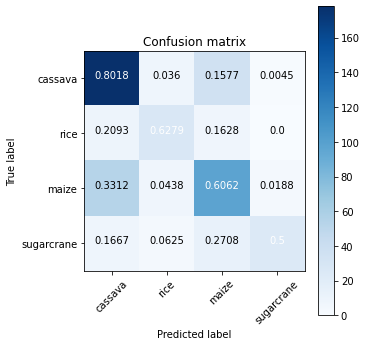

In [43]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')

# Downsample
# compute the confusion matrix
confusion_mtx = confusion_matrix(act_label , pred_label) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['cassava','rice','maize','sugarcrane'],normalize=True)
sum(act_label==pred_label)/len(act_label)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(act_label, pred_label))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       222
           1       0.60      0.63      0.61        43
           2       0.64      0.61      0.62       160
           3       0.86      0.50      0.63        48

    accuracy                           0.69       473
   macro avg       0.70      0.63      0.66       473
weighted avg       0.69      0.69      0.69       473



0.6680761099365751

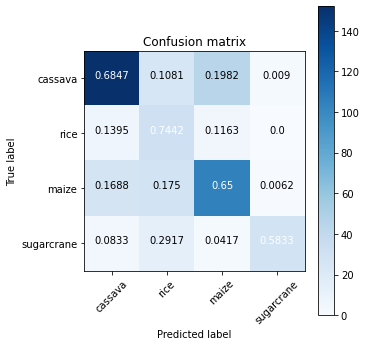

In [28]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')

# Downsample
# compute the confusion matrix
confusion_mtx = confusion_matrix(act_label , pred_label) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['cassava','rice','maize','sugarcrane'],normalize=True)
sum(act_label==pred_label)/len(act_label)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(act_label, pred_label))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74       222
           1       0.33      0.74      0.45        43
           2       0.67      0.65      0.66       160
           3       0.90      0.58      0.71        48

    accuracy                           0.67       473
   macro avg       0.68      0.67      0.64       473
weighted avg       0.73      0.67      0.68       473



0.6490486257928119

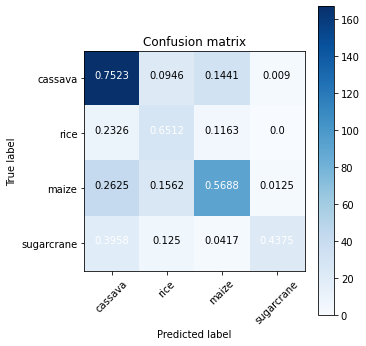

In [35]:
# Upsample
# compute the confusion matrix
confusion_mtx = confusion_matrix(act_label , pred_label) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['cassava','rice','maize','sugarcrane'],normalize=True)
sum(act_label==pred_label)/len(act_label)

0.718816067653277

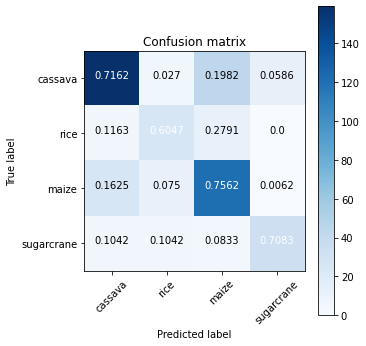

In [25]:
# Down Sampling
# compute the confusion matrix
confusion_mtx = confusion_matrix(act_label , pred_label) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['cassava','rice','maize','sugarcrane'],normalize=True)
sum(act_label==pred_label)/len(act_label)